In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

import cudf

import pickle
import cupy as cp

from cuml.ensemble import RandomForestRegressor as curfr
#from cuml.ensemble import GradientBoostingRegressor as cugbr
from cuml.linear_model import LinearRegression as cuLinearRegression
from cuml.svm import SVR, SVC
from cuml.linear_model import LogisticRegression as cuLogRe
from cuml.linear_model import MBSGDClassifier as cumlMBSGDClassifier
from cuml.linear_model import MBSGDRegressor as cumlMBSGDRegressor
from cuml.solvers import SGD as cumlSGD

from cuml.neighbors import KNeighborsRegressor

from cuml.experimental.preprocessing import SimpleImputer
from cuml.experimental.preprocessing import StandardScaler,MinMaxScaler
from cuml.metrics.regression import r2_score
from cuml.metrics.regression import mean_absolute_error,mean_squared_error
from cuml.metrics import accuracy_score

from cuml.cluster import DBSCAN

from sklearn.metrics import f1_score,confusion_matrix

from dask_cuda import LocalCUDACluster
import dask_cudf

from cuml.dask.common import utils as dask_utils
from dask.distributed import Client, wait

from sklearn.preprocessing import scale

import seaborn as sns
sns.set(font_scale = 2)

import xgboost as xgb


In [2]:
%%time
# train_features = cudf.read_csv('DB/new_data/training_features.csv')
# test_features=cudf.read_csv('DB/new_data/testing_features.csv')
# train_labels=cudf.read_csv('DB/new_data/training_labels.csv')
# test_labels=cudf.read_csv('DB/new_data/testing_labels.csv')

train_features=cudf.read_csv('DB/data_fill/training_features.csv')
test_features=cudf.read_csv('DB/data_fill/testing_features.csv')
train_labels=cudf.read_csv('DB/data_fill/training_labels.csv')
test_labels=cudf.read_csv('DB/data_fill/testing_labels.csv')


print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (804384, 9)
Testing Feature Size:   (344737, 9)
Training Labels Size:   (804384, 1)
Testing Labels Size:    (344737, 1)
CPU times: user 2.82 s, sys: 1.28 s, total: 4.09 s
Wall time: 6.42 s


In [3]:
train_features.head(10)
if 'new_tsp' in train_features.columns:
    train_features=train_features.drop('new_tsp', axis=1)
if 'new_tsp' in test_features.columns:
    test_features=test_features.drop('new_tsp', axis=1)
train_features.head(10)

,temperature,humidity,light,pressure,weekday,quarter,month,hour
0,21.000000,49.000000,0.486400,1029.189345,2,4,11,10
1,26.418382,43.737592,74.076609,1008.463713,3,3,9,20
2,22.207622,47.807888,2.432000,996.281490,4,1,3,14
3,18.000000,44.000000,2.432000,1015.782503,2,1,3,1
4,21.720532,59.944791,2.432000,1011.012292,6,2,5,4
5,26.363619,55.828613,46.910056,1009.363670,7,3,7,22
6,19.477142,31.743955,2.432000,1008.765233,2,1,3,15
7,29.197552,63.902686,17.388716,1012.552965,6,3,7,23
8,21.000000,44.000000,0.972800,1001.165509,3,2,4,7
9,15.190000,44.990000,0.000000,1021.940000,7,4,12,8


In [4]:
imputer = SimpleImputer(missing_values=cp.nan, strategy='median')
imputer.fit(train_features)

#print(train_features.type)
#scaler = StandardScaler()
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

scaler = MinMaxScaler(feature_range=(0, 1))
# Fit on the training data
scaler.fit(X)
scaler.fit(X_test)

# Transform both the training and testing data
X = cudf.DataFrame(scaler.transform(X))
X_test = cudf.DataFrame(scaler.transform(X_test))

# y = train_labels.as_matrix().reshape(-1,1)
# y = scaler.fit_transform(y).flatten()
# y_test= test_labels.as_matrix().reshape(-1,1)
# y_test = scaler.fit_transform(y_test).flatten()
y = cudf.Series(train_labels.values)
y_test= cudf.Series(test_labels.values)

In [5]:
y.head(10)

0    10
1     1
2     5
3     4
4     9
5     1
6     5
7     9
8     6
9     8
dtype: int64

In [6]:
y_test=y_test.astype(np.float32)
X_test=X_test.astype(np.float32)
X=X.astype(np.float32)
y=y.astype(np.float32)

result_pd=pd.DataFrame()

Linear Regression

Support Vector Machine Regression

Random Forest Regression

Gradient Boosting Regression

K-Nearest Neighbors Regression

In [7]:
def pro_pred(y_pred):
    propre=np.round(y_pred)
    return propre

def addToResult(result_pd,pred,model_name):
    #global re_pd
    #print(pred_re.type)
    #pred_re=pred_re.set_index(name=model_name)
    #print(pred_re.columns)
    #pred_re.columns=[model_name]
    pred=pd.DataFrame({model_name:pred.to_array()})
    re_pd= pd.concat([result_pd,pred],axis=1)
    return re_pd

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model,filename):
    global y_test
    global X_test
    global X
    global y
    
    # Train the model
    model.fit(X, y)
    # Make predictions and evalute
    
    model_pred = model.predict(X_test,convert_dtype=True)
    model_pred=pro_pred(model_pred)
    
    #model_mae = mean_absolute_error(y_test.astype(np.float32), model_pred.astype(np.float32))
    model_mae = mean_absolute_error(y_test, model_pred)
    model_mse = mean_squared_error(y_test, model_pred)

    # Compute confusion matrix
    #print(cnf_matrix)
    model_r2_score= r2_score(y_test, model_pred)
    #model_max_error= max_error(y_test, model_pred)
    #print(model_pred)
    # save the model to disk
    filename = 'stored_model/'+filename+'.sav'
    pickle.dump(model, open(filename, 'wb'))
    return model_pred, model_mae, model_mse,model_r2_score

def fit_and_predict(model,filename):
    global y_test
    global X_test
    global X
    global y
    # Train the model
    model.fit(X, y)
    # Make predictions and evalute
    model_pred = model.predict(X_test,convert_dtype=True)
    model_pred=pro_pred(model_pred)
    
    filename = 'stored_model/'+filename+'.sav'
    pickle.dump(model, open(filename, 'wb'))
    return model_pred

def evaluate(y_test, model_pred):  
    #model_pred=pro_pred(model_pred)
    #model_mae = mean_absolute_error(y_test.astype(np.float32), model_pred.astype(np.float32))
    model_mae = mean_absolute_error(y_test, model_pred)
    model_mse = mean_squared_error(y_test, model_pred)
    model_r2_score= r2_score(y_test, model_pred)
    return model_mae, model_mse,model_r2_score

In [12]:
%%time
t0 = time()
logRe_cuml = cuLogRe()
#logRe_pred, logRe_mae,logRe_mse,logRe_r2_score= fit_and_evaluate(logRe_cuml,'logRe_cmul_full')
logRe_pred= fit_and_predict(logRe_cuml,'logRe_cmul_full')
logRe_mae,logRe_mse,logRe_r2_score=evaluate(y_test, logRe_pred)


t1 = time()
logRe_t=t1-t0

print('LogisticRegression Performance on the test set: \n MAE = %0.4f' % logRe_mae,
      "\n MSE = %0.4f "% logRe_mse,
      "\n r2_sccore = %0.4f' "% logRe_r2_score,   
      "\n time = %0.4f' "% logRe_t)

[E] [00:33:15.101693] L-BFGS line search failed
LogisticRegression Performance on the test set: 
 MAE = 3.0818 
 MSE = 17.2191  
 r2_sccore = -0.8956'  
 time = 1.2915' 
CPU times: user 904 ms, sys: 392 ms, total: 1.3 s
Wall time: 1.29 s


In [82]:
result_pd=addToResult(result_pd,logRe_pred,'LogisticRegression')

In [83]:
result_pd=addToResult(result_pd,lr_pred,'Linear Regression')

In [85]:
result_pd=addToResult(result_pd,cu_sgd_pred,'MBSGD')

In [120]:
%%time
t0 = time()
lr_cuml = cuLinearRegression(fit_intercept=True,
                              normalize=True,
                              algorithm='eig')
#lr_pred, lr_mae,lr_mse,lr_r2_score= fit_and_evaluate(lr_cuml,'lr_cmul_full')

lr_pred= fit_and_predict(lr_cuml,'lr_cmul_full')
lr_mae,lr_mse,lr_r2_score=evaluate(y_test, lr_pred)

t1 = time()
lr_t=t1-t0

print('Linear Regression Performance on the test set: \n MAE = %0.4f' % lr_mae,
      "\n MSE = %0.4f "% lr_mse,
      "\n r2_sccore = %0.4f' "% lr_r2_score,   
      "\n time = %0.4f' "% lr_t)

Linear Regression Performance on the test set: 
 MAE = 2.5380 
 MSE = 8.8982  
 r2_sccore = 0.0204'  
 time = 0.0245' 
CPU times: user 20 ms, sys: 8 ms, total: 28 ms
Wall time: 24.7 ms


In [17]:
%%time

#from cuml.linear_model import MBSGDClassifier as cumlMBSGDClassifierbatch_size为2的倍数
t0 = time()

#learning_rate='optimal' not supported!!!
cu_sgd = cumlSGD(learning_rate='constant', eta0=0.01, epochs=2000,
                fit_intercept=True, batch_size=32,
                tol=0.0, penalty='none', loss='squared_loss')


cu_sgd_pred= fit_and_predict(cu_sgd,'cu_sgd_cmul_full')
cu_sgd_mae,cu_sgd_mse,cu_sgd_r2_score=evaluate(y_test, cu_sgd_pred)
#cusgd_pred = cu_sgd.predict(X_test).to_array()

t1 = time()
cusgd_t=t1-t0

# print(cusgd_pred)
# cusgd_mae = mean_absolute_error(y_test, np.round(cusgd_pred))
# cusgd_mse = mean_squared_error(y_test, np.round(cusgd_pred))
# cusgd_r2_score= r2_score(y_test, np.round(cusgd_pred))

print('Stochastic Gradient Descent Performance on the test set: \n MAE = %0.4f' % cu_sgd_mae,
      "\n MSE = %0.4f "% cu_sgd_mse,
      "\n r2_sccore = %0.4f' "% cu_sgd_r2_score,   
      "\n time = %0.4f' "% cusgd_t)

Stochastic Gradient Descent Performance on the test set: 
 MAE = 2.5430 
 MSE = 8.9065  
 r2_sccore = 0.0195'  
 time = 2995.5147' 
CPU times: user 44min 43s, sys: 5min 57s, total: 50min 40s
Wall time: 49min 55s


In [18]:
%%time

#from cuml.linear_model import MBSGDClassifier as cumlMBSGDClassifier
t0 = time()

cu_mbsgd_classifier = cumlMBSGDClassifier(learning_rate='constant', eta0=0.01, epochs=2000,
                                        fit_intercept=True,
                                        batch_size=64, tol=0.0,
                                        penalty='l2',
                                        loss='squared_loss',
                                        alpha=0.5)

cu_mbsgdC_pred= fit_and_predict(cu_mbsgd_regressor,'cu_sgd_cmul_full')
cu_mbsgdC_mae,cu_mbsgdC_mse,cu_mbsgdC_r2_score=evaluate(y_test, mbsgdR_pred)

# cu_mbsgd_regressor.fit(X, y)
# mbsgdR_pred = cu_mbsgd_regressor.predict(X_test).to_array()

t1 = time()
cu_mbsgdC_t=t1-t0


# mbsgdR_mae = mean_absolute_error(y_test, np.round(mbsgdR_pred))
# mbsgdR_mse = mean_squared_error(y_test, np.round(mbsgdR_pred))
# mbsgdR_r2_score= r2_score(y_test, np.round(mbsgdR_pred))
print('cumlMBSGDClassifier Performance on the test set: \n MAE = %0.4f' % cu_mbsgdC_mae,
      "\n MSE = %0.4f "% cu_mbsgdC_mse,
      "\n r2_sccore = %0.4f' "% cu_mbsgdC_r2_score,   
      "\n time = %0.4f' "% cu_mbsgdC_t)

result_pd=addToResult(result_pd,cu_mbsgdC_pred,'MBSGD_C')

cumlMBSGDClassifier Performance on the test set: 
 MAE = 2.5831 
 MSE = 9.1539  
 r2_sccore = -0.0077'  
 time = 1930.8243' 
CPU times: user 29min 24s, sys: 3min 27s, total: 32min 51s
Wall time: 32min 10s


In [88]:
result_pd=addToResult(result_pd,cu_mbsgdR_pred,'MBSGD_R')

,0,0,0,0,0,0,lr,Linear Regression,LogisticRegression,Linear Regression,MBSGD,MBSGD_C,MBSGD_R,MBSGD_R
0,8.0,8.0,8.0,8.0,8.0,8.0,6.0,6.0,7.0,6.0,6.0,6.0,6.0,6.0
1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,6.0,6.0,6.0
2,8.0,8.0,8.0,8.0,8.0,8.0,7.0,7.0,7.0,7.0,7.0,6.0,6.0,6.0
3,5.0,5.0,5.0,5.0,5.0,5.0,7.0,7.0,4.0,7.0,7.0,6.0,6.0,6.0
4,8.0,8.0,8.0,8.0,8.0,8.0,5.0,5.0,8.0,5.0,5.0,6.0,6.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344732,8.0,8.0,8.0,8.0,8.0,8.0,5.0,5.0,8.0,5.0,5.0,6.0,6.0,6.0
344733,8.0,8.0,8.0,8.0,8.0,8.0,7.0,7.0,7.0,7.0,7.0,6.0,6.0,6.0
344734,4.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,4.0,5.0,5.0,6.0,6.0,6.0
344735,4.0,4.0,4.0,4.0,4.0,4.0,6.0,6.0,4.0,6.0,6.0,6.0,6.0,6.0


In [19]:
%%time

#from cuml.linear_model import MBSGDClassifier as cumlMBSGDClassifier
t0 = time()

cu_mbsgd_regressor = cumlMBSGDRegressor(learning_rate='constant', eta0=0.01, epochs=2000,
                                        fit_intercept=True,
                                        batch_size=64, tol=0.0,
                                        penalty='l2',
                                        loss='squared_loss',
                                        alpha=0.5)

cu_mbsgdR_pred= fit_and_predict(cu_mbsgd_regressor,'cu_sgd_cmul_full')
cu_mbsgdR_mae,cu_mbsgdR_mse,cu_mbsgdR_r2_score=evaluate(y_test, mbsgdR_pred)

# cu_mbsgd_regressor.fit(X, y)
# mbsgdR_pred = cu_mbsgd_regressor.predict(X_test).to_array()

t1 = time()
cu_mbsgdR_t=t1-t0
cu_mbsgdR_t=t1-t0
print(cu_mbsgdR_pred)

# mbsgdR_mae = mean_absolute_error(y_test, np.round(mbsgdR_pred))
# mbsgdR_mse = mean_squared_error(y_test, np.round(mbsgdR_pred))
# mbsgdR_r2_score= r2_score(y_test, np.round(mbsgdR_pred))
print('MBSGDRegressor Performance on the test set: \n MAE = %0.4f' % cu_mbsgdR_mae,
      "\n MSE = %0.4f "% cu_mbsgdR_mse,
      "\n r2_sccore = %0.4f' "% cu_mbsgdR_r2_score,   
      "\n time = %0.4f' "% cu_mbsgdR_t)

NameError: name 'mbsgd_pred' is not defined

In [24]:
cu_mbsgdR_t=t1-t0
print(cu_mbsgdR_pred)

# mbsgdR_mae = mean_absolute_error(y_test, np.round(mbsgdR_pred))
# mbsgdR_mse = mean_squared_error(y_test, np.round(mbsgdR_pred))
# mbsgdR_r2_score= r2_score(y_test, np.round(mbsgdR_pred))
print('MBSGDRegressor Performance on the test set: \n MAE = %0.4f' % cu_mbsgdR_mae,
      "\n MSE = %0.4f "% cu_mbsgdR_mse,
      "\n r2_sccore = %0.4f' "% cu_mbsgdR_r2_score,   
      "\n time = %0.4f' "% cu_mbsgdR_t)

0         6.0
1         6.0
2         6.0
3         6.0
4         6.0
         ... 
344732    6.0
344733    6.0
344734    6.0
344735    6.0
344736    6.0
Length: 344737, dtype: float32
MBSGDRegressor Performance on the test set: 
 MAE = 2.5831 
 MSE = 9.1539  
 r2_sccore = -0.0077'  
 time = 288.7484' 


In [20]:
# This will use all GPUs on the local host by default
cluster = LocalCUDACluster(threads_per_worker=1)
c = Client(cluster)

# Query the client for all connected workers
workers = c.has_what().keys()
n_workers = len(workers)
print(n_workers)
n_partitions = n_workers

def distribute(X, y):
    # First convert to cudf (with real data, you would likely load in cuDF format to start)
    X_cudf = cudf.DataFrame(X)
    y_cudf = cudf.Series(y)

    # Partition with Dask
    # In this case, each worker will train on 1/n_partitions fraction of the data
    X_dask = dask_cudf.from_cudf(X_cudf, npartitions=n_partitions)
    y_dask = dask_cudf.from_cudf(y_cudf, npartitions=n_partitions)

    # Persist to cache the data in active memory
    X_dask, y_dask = \
      dask_utils.persist_across_workers(c, [X_dask, y_dask], workers=workers)
    
    return X_dask, y_dask

X_train_dask, y_train_dask = distribute(X, y)
X_test_dask, y_test_dask = distribute(X_test, y_test)

/opt/conda/envs/rapids/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37304 instead
  warnings.warn(


1


In [21]:
%%time
t0 = time()
#svm = SVR(C = 1, gamma = 0.15)核函数：径向基核函数 高斯变换 线性的分割 变成非线性分割 
svr = SVR(kernel='rbf', gamma='scale', C=1, epsilon=0.1)
#svm = SVC(kernel='poly', degree=2, gamma='auto', C=1)

svr_pred= fit_and_predict(svr,'cu_svr_full')
svr_mae,svr_mse,svr_r2_score=evaluate(y_test, svr_pred)

#svm_pred,svm_mae,svm_mse,svm_r2_score= fit_and_evaluate(svm,'svm_cmul_full')
t1 = time()
svr_t=t1-t0
print('Support Vector Machine Regression Performance on the test set: \n MAE = %0.4f' % svr_mae,
      "\n MSE = %0.4f "% svr_mse,
      "\n Max error = %0.4f "% svr_r2_score,
      "\n time = %0.4f' "% svr_t)

result_pd=addToResult(result_pd,svr_pred,'SVR')

Support Vector Machine Regression Performance on the test set: 
 MAE = 1.6671 
 MSE = 5.3185  
 Max error = 0.4145  
 time = 288.7484' 
CPU times: user 3min 11s, sys: 1min 43s, total: 4min 54s
Wall time: 4min 48s


In [102]:
%%time
t0 = time()
#svm = SVR(C = 1000, gamma = 0.1)当C趋近于很小的时：意味着可以有更大的错误容忍
svc = SVC(kernel='rbf', C = 1, gamma = 0.15)
svc_pred= fit_and_predict(svc,'cu_svc_full')
cu_svc_mae,cu_svc_mse,cu_svc_r2_score=evaluate(y_test, svc_pred)
#svc_mae,svc_mse,svc_r2_score,svc_max_error,svc_pred= fit_and_evaluate(svc,'svm')
t1 = time()
cu_svc_t=t1-t0
print('Support Vector Machine classifier performance on the test set: \n MAE = %0.4f' % cu_svc_mae,
      "\n MSE = %0.4f "% cu_svc_mse,
      "\n r2 score = %0.4f "% cu_svc_r2_score,
      "\n time = %0.4f' "% cu_svc_t)

Support Vector Machine classifier performance on the test set: 
 MAE = 2.2546 
 MSE = 12.0681  
 r2 score = -0.3285  
 time = 237.3905' 
CPU times: user 2min 47s, sys: 1min 14s, total: 4min 2s
Wall time: 3min 57s


In [103]:
print(svc_pred)

0         9.0
1         2.0
2         7.0
3         9.0
4         2.0
         ... 
344732    1.0
344733    9.0
344734    5.0
344735    5.0
344736    1.0
Length: 344737, dtype: float32


In [104]:
result_pd=addToResult(result_pd,svc_pred,'SVC')

In [105]:
#%%timeit -n 1 -r 1
t0 = time()
random_forest = curfr(max_features=1.0,n_streams=1,
                   n_bins=8,n_estimators=40, random_state=60)


rf_pred= fit_and_predict(random_forest,'cu_svr_full')
cu_rf_mae,cu_rf_mse,cu_rf_r2_score=evaluate(y_test, rf_pred)

#rf_pred,rf_mae, rf_mse,rf_r2_score = fit_and_evaluate(random_forest,'rf_cmul_full')
t1 = time()
cu_rf_t=t1-t0
print('Random forest Performance on the test set: \n MAE = %0.4f' % cu_rf_mae,
      "\n MSE = %0.4f "% cu_rf_mse,
      "\n r2 score = %0.4f "% cu_rf_r2_score,
      "\n time = %0.4f' "% cu_rf_t)

Random forest Performance on the test set: 
 MAE = 0.9794 
 MSE = 2.2952  
 Max error = 0.7473  
 time = 1.7986' 


In [106]:
result_pd=addToResult(result_pd,rf_pred,'Random Forest')

In [108]:
dtrain = xgb.DMatrix(X, label=y)
dvalidation = xgb.DMatrix(X_test, label=y_test)

# instantiate params
params = {}

# general params
general_params = {'silent': 1}
params.update(general_params)

# booster params
n_gpus = 1
booster_params = {}

if n_gpus != 0:
    booster_params['tree_method'] = 'gpu_hist'
    booster_params['n_gpus'] = n_gpus
params.update(booster_params)

# learning task params
#learning_task_params = {'eval_metric': 'auc', 'objective': 'binary:logistic'}
learning_task_params = {'eval_metric': 'mae', 'objective': 'reg:squarederror'}

params.update(learning_task_params)
print(params)

# model training settings
evallist = [(dvalidation, 'validation'), (dtrain, 'train')]
num_round = 10

t=time()
bst = xgb.train(params, dtrain, num_round, evallist)
t1=time()

xgb_pred=bst.predict(dvalidation)

xgb_t=t1-t

#print(np.round(xgb_pred))

xgb_mae,xgb_mse,xgb_r2_score=evaluate(y_test, xgb_pred)

# xgb_mae = mean_absolute_error(y_test, np.round(xgb_pred))
# xgb_mse = mean_squared_error(y_test, np.round(xgb_pred))
# xgb_r2_score= r2_score(y_test, np.round(xgb_pred))

print('XGBoost on the test set: \n MAE = %0.4f' % xgb_mae,
      "\n MSE = %0.4f "% xgb_mse,
      "\n r2 score = %0.4f "% xgb_r2_score,
      "\n time = %0.4f' "% xgb_t)

#result_pd=addToResult(result_pd,xgb_pred,'XG_boost')
pred=pd.DataFrame({'xg boost':xgb_pred})
result_pd= pd.concat([result_pd,pred],axis=1)

{'silent': 1, 'tree_method': 'gpu_hist', 'n_gpus': 1, 'eval_metric': 'mae', 'objective': 'reg:squarederror'}
[08:54:01] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1612969829206/work/include/xgboost/generic_parameters.h:39: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[08:54:01] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1612969829206/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-mae:3.83897	train-mae:3.84141
[1]	validation-mae:2.95052	train-mae:2.95093
[2]	validation-mae:2.36471	train-mae:2.36333
[3]	validation-mae:2.01296	train-ma

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

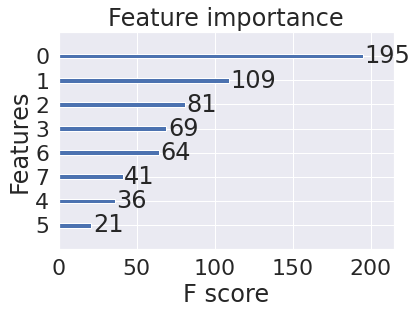

In [109]:
from xgboost import plot_importance
xgb.plot_importance(bst)

In [111]:
#%%timeit -n 1 -r 1
t0 = time()
knn = KNeighborsRegressor(n_neighbors=10)

knn_pred= fit_and_predict(knn,'cu_knn_full')
cu_knn_mae,cu_knn_mse,cu_knn_r2_score=evaluate(y_test, rf_pred)

#knn_pred, knn_mae,knn_mse,knn_r2_score = fit_and_evaluate(knn,'knn_cmul_full')
t1 = time()
knn_t=t1-t0
print('K-NeighborsRegression Performance on the test set: \n MAE = %0.4f' % cu_knn_mae,
      "\n MSE = %0.4f "% cu_knn_mse,
      "\n r2 score = %0.4f "%cu_knn_r2_score, 
      "\n time = %0.4f' "% knn_t)

result_pd=addToResult(result_pd,knn_pred,'KNN')

K-NeighborsRegression Performance on the test set: 
 MAE = 0.9794 
 MSE = 2.2952  
 r2 score = 0.7473  
 time = 5.2552' 


In [ ]:
t0 = time()

dbscan = DBSCAN(eps = 1.0, min_samples = 1)
dbscan_float.fit(gdf_float)

dbscan_pred= fit_and_predict(dbscan,'cu_dbscan_full')
cu_dbscan_mae,cu_dbscan_mse,cu_dbscan_r2_score=evaluate(y_test, dbscan_pred)

t1 = time()
dbscan_t=t1-t0


print('DBSCAN Performance on the test set: \n MAE = %0.4f' % cu_dbscan_mae,
      "\n MSE = %0.4f "% cu_dbscan_mse,
      "\n r2 score = %0.4f "%cu_dbscan_r2_score, 
      "\n time = %0.4f' "% dbscan_t)

result_pd=addToResult(result_pd,dbscan_pred,'DBSCAN')

In [2]:
result_pd

NameError: name 'result_pd' is not defined

In [1]:
result_pd.to_csv('DB/result/result.csv', index = False)

NameError: name 'result_pd' is not defined

In [115]:
#without process lr MAE = 1.5687 svm MAE = 1.2624 random forest MAE = 0.4122 GB MAE = 0.9731  KNN MAE = 0.7794
#without process lr MAE = 1.5356  svm MAE = 1.2192 random forest MAE = 0.3905 GB MAE =  0.9134  KNN MAE = 0.7670

lr_acsore=accuracy_score(y_test, lr_pred)
rf_acsore=accuracy_score(y_test, rf_pred)
xgb_acsore=accuracy_score(y_test, xgb_pred)
logRe_acsore=accuracy_score(y_test, logRe_pred)
cu_mbsgdR_acsore=accuracy_score(y_test, cu_mbsgdR_pred)
cu_mbsgdC_acsore=accuracy_score(y_test, cu_mbsgdC_pred)
#gb_acsore=accuracy_score(y_test,gb_pred, normalize=True)
knn_acsore=accuracy_score(y_test,knn_pred)
print(lr_acsore,rf_acsore,knn_acsore,xgb_acsore)

0.10942254215478897 0.42861658334732056 0.949053943157196 0.233047217130661


In [127]:
#print(logRe_mae, lr_mae, cu_rf_mae, svr_mae, knn_mae,xgb_mae,cusgd_mae)
print(logRe_t, lr_t, cu_rf_t, svr_t, knn_t,xgb_t,cusgd_t)

model_comparison = pd.DataFrame({'model': ['LogisticRegression','Linear Regression','Stochastic Gradient Descent','MBSGDRegression',
                                           'MBSGDClassifier','Support Vector Regression','Support Vector Classfier',
                                           'Random Forest', 'XG Boost','K-Nearest Neighbors'],
                                 'mae': np.array([logRe_mae, lr_mae,cu_sgd_mae, cu_mbsgdR_mae, 
                                                  cu_mbsgdC_mae,svr_mae,cu_svc_mae,
                                                  cu_rf_mae, xgb_mae, cu_knn_mae]).astype(float),
                                 'time': np.array([logRe_t, lr_t, cu_sgd_t, cu_mbsgdR_t,
                                                   cu_mbsgdC_t,svr_t,cu_svc_t, 
                                                   cu_rf_t, xgb_t, knn_t]).astype(float)})


print(model_comparison)
#2.201003211178209 0.11234611537680582 1.062275800350447 0.18753431147676597
#0.06550335884094238 59.31387782096863 18.222867965698242 37.90412163734436

#2.537987 0.9786156 2.7027068 0.09342774
#0.028433799743652344 1.3301267623901367 346.9047305583954 5.238832950592041,

0.1520519256591797 0.024474620819091797 1.7985765933990479 288.7484173774719 5.2552361488342285 0.14979028701782227 2995.5147228240967
                         model       mae         time
0           LogisticRegression  3.103131     0.152052
1            Linear Regression  2.537987     0.024475
2  Stochastic Gradient Descent  2.542968  1924.368763
3              MBSGDRegression  2.583053   288.748417
4              MBSGDClassifier  2.583053  1930.824276
5    Support Vector Regression  1.667071   288.748417
6     Support Vector Classfier  2.254585   237.390467
7                Random Forest  0.979422     1.798577
8                     XG Boost  1.463393     0.149790
9          K-Nearest Neighbors  0.979422     5.255236


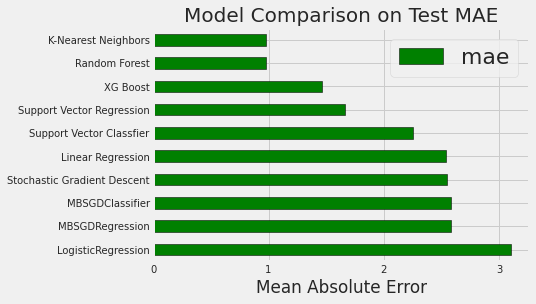

In [128]:
dt = str(time())

plt.style.use('fivethirtyeight')
#figsize(8, 6)

model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'green', edgecolor = 'black')

plt.ylabel(''); plt.yticks(size = 10); 
plt.xlabel('Mean Absolute Error'); 
plt.xticks(size = 10)

plt.title('Model Comparison on Test MAE', size = 20);
plt.savefig('./images/rapids_mae'+dt+'.png',dpi=500,bbox_inches = 'tight') 
plt.show()

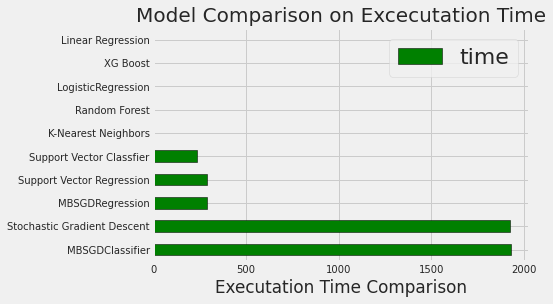

In [130]:
dt = str(time())

plt.style.use('fivethirtyeight')

model_comparison.sort_values('time', ascending = False).plot(x = 'model', y = 'time', kind = 'barh',
                                                           color = 'green', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 10); 
plt.xlabel('Executation Time Comparison'); 
plt.xticks(size = 10)

plt.title('Model Comparison on Excecutation Time', size = 20);
plt.savefig('./images/rapids_time'+dt+'.png',dpi=500) 
plt.show()

In [131]:
def plot_confusion_matrix(cm,title):
    cmap=plt.cm.Blues
    leng=len(cm)
    classes=np.arange(1, leng+1)
    dt = str(time())
    print(classes)
    #harvest = np.random.randint(4, 10, (10, 10))
    fig, ax = plt.subplots()
    im = ax.imshow(cm,cmap="YlGnBu")#,vmin=0, vmax=500
    sns.set_theme()
    #im = sns.heatmap(cm,linewidths=.5,cmap=cmap, vmin=0, vmax=500)
    sticks=np.arange(0,len(classes))

    # We want to show all ticks...
    ax.set_xticks(sticks)
    ax.set_yticks(sticks)
    #axes.set_xticklabels(["A", "B", "C", "D", "E"])
    #ax.set_yticks(classes)
    # ... and label them with the respective list entries
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    #thresh = cm.max() / 10.

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in sticks:
        for j in sticks:
            text = ax.text(j, i, cm[i, j],ha="center", va="center",fontsize=10)

    ax.set_title(title)
    fig.tight_layout()
    plt.savefig('./images/maedropna_withprocess'+title+dt+'.png',quality=100,dpi=500) 
    plt.show()
    
def make_confusion_matrix(y_test, model_pred):
    cf_m = confusion_matrix(y_test, model_pred)
    return cf_m

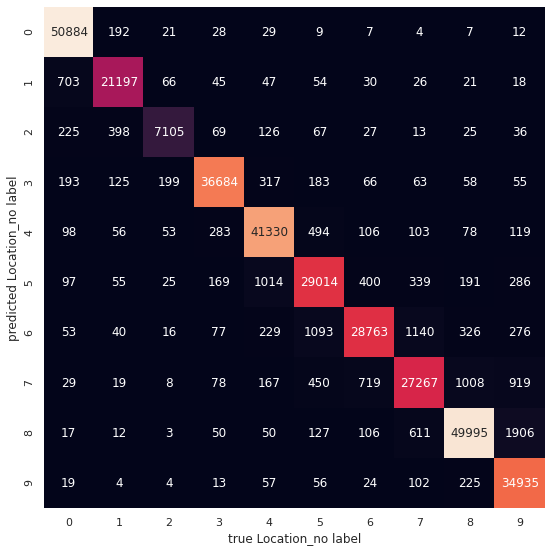

In [135]:
knn_cnf_matrix= make_confusion_matrix(y_test.to_array(), knn_pred.to_array())
plt.figure(figsize=(8,10))
sns.heatmap(knn_cnf_matrix.T, square=True, annot=True, fmt='d', cbar=False,
            #xticklabels=faces.target_names,
            #yticklabels=faces.target_names
           )
plt.xlabel('true Location_no label')
plt.ylabel('predicted Location_no label');

# print(knn_cnf_matrix)
# plt.figure(figsize=(8,10))
# plot_confusion_matrix(knn_cnf_matrix, title='KNN Confusion matrix')
# plt.show()

In [88]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [10,20,50,80,100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [89]:
# Create the model to use for hyperparameter tuning
from cuml import Ridge as cumlRidge


model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [90]:
# Fit on the training data
t0 = time()
random_cv.fit(X, y)
t1 = time()
print('Done learning {0:.3f} sec'.format(t1-t0))

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Done learning 728.284 sec


In [91]:
# Get all of the cv results and sort by the test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)
random_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
12,306.285071,3.791618,0.855594,0.010745,1500,10,6,log2,15,huber,"{'n_estimators': 1500, 'min_samples_split': 10...",-0.396918,-0.386701,-0.394414,-0.396409,-0.393610,0.004098,1,-0.042560,-0.040545,-0.043245,-0.043478,-0.042457,0.001154
22,130.481129,1.000426,0.265605,0.040018,1500,6,1,auto,5,huber,"{'n_estimators': 1500, 'min_samples_split': 6,...",-0.536804,-0.526379,-0.524561,-0.544207,-0.532988,0.007986,2,-0.342247,-0.342857,-0.341410,-0.341051,-0.341891,0.000706
14,4.960023,0.083927,0.056365,0.000402,80,6,4,sqrt,10,ls,"{'n_estimators': 80, 'min_samples_split': 6, '...",-0.550553,-0.522717,-0.538366,-0.546296,-0.539483,0.010622,3,-0.372685,-0.365453,-0.375961,-0.373641,-0.371935,0.003927
24,4.290845,0.139594,0.040583,0.004159,50,2,2,log2,10,ls,"{'n_estimators': 50, 'min_samples_split': 2, '...",-0.566674,-0.540516,-0.545812,-0.553606,-0.551652,0.009844,4,-0.418519,-0.407712,-0.394890,-0.394812,-0.403983,0.009899
21,153.140030,6.905780,0.383297,0.006598,900,6,4,None,10,lad,"{'n_estimators': 900, 'min_samples_split': 6, ...",-0.569456,-0.549446,-0.573961,-0.526652,-0.554879,0.018727,5,-0.381191,-0.413211,-0.399516,-0.327359,-0.380319,0.032619
17,24.132552,1.435009,0.052834,0.002009,80,4,6,None,10,lad,"{'n_estimators': 80, 'min_samples_split': 4, '...",-0.634903,-0.569072,-0.633731,-0.617376,-0.613771,0.026721,6,-0.512230,-0.489044,-0.522221,-0.476739,-0.500058,0.018059
2,80.727845,1.181191,0.469362,0.015988,1500,6,8,sqrt,5,lad,"{'n_estimators': 1500, 'min_samples_split': 6,...",-0.630182,-0.605026,-0.616085,-0.635091,-0.621596,0.011840,7,-0.555967,-0.561381,-0.555894,-0.552808,-0.556512,0.003086
13,10.371789,0.359784,0.024455,0.000371,20,2,6,log2,15,lad,"{'n_estimators': 20, 'min_samples_split': 2, '...",-0.641214,-0.603217,-0.634164,-0.651088,-0.632421,0.017900,8,-0.489525,-0.476957,-0.482979,-0.492917,-0.485594,0.006134
8,73.992681,0.994838,0.369735,0.006084,1100,10,8,log2,5,lad,"{'n_estimators': 1100, 'min_samples_split': 10...",-0.645731,-0.618413,-0.640770,-0.652309,-0.639305,0.012738,9,-0.583716,-0.582934,-0.593089,-0.581147,-0.585221,0.004637
20,2.136960,0.105299,0.027730,0.001654,20,2,8,log2,15,ls,"{'n_estimators': 20, 'min_samples_split': 2, '...",-0.648841,-0.630585,-0.658408,-0.653668,-0.647875,0.010540,10,-0.498620,-0.507351,-0.515544,-0.500391,-0.505476,0.006666


In [92]:
random_cv.best_estimator_

GradientBoostingRegressor(loss='huber', max_depth=15, max_features='log2',
                          min_samples_leaf=6, min_samples_split=10,
                          n_estimators=1500, random_state=42)

In [93]:
# Create a range of trees to evaluate
trees_grid = {'n_estimators': [10,20,50,70,100, 150, 200, 250, 300, 350, 400, 450, 500,
                               550, 600, 650, 700, 750, 800,1000,1100,1200]}

model = GradientBoostingRegressor(loss = 'lad', max_depth = 5,
                                  min_samples_leaf = 6,
                                  min_samples_split = 6,
                                  max_features = None,
                                  random_state = 42)

# Grid Search Object using the trees range and the random forest model
grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [94]:
# Fit the grid search
grid_search.fit(X, y)

Fitting 4 folds for each of 22 candidates, totalling 88 fits


GridSearchCV(cv=4,
             estimator=GradientBoostingRegressor(loss='lad', max_depth=5,
                                                 min_samples_leaf=6,
                                                 min_samples_split=6,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'n_estimators': [10, 20, 50, 70, 100, 150, 200, 250,
                                          300, 350, 400, 450, 500, 550, 600,
                                          650, 700, 750, 800, 1000, 1100,
                                          1200]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

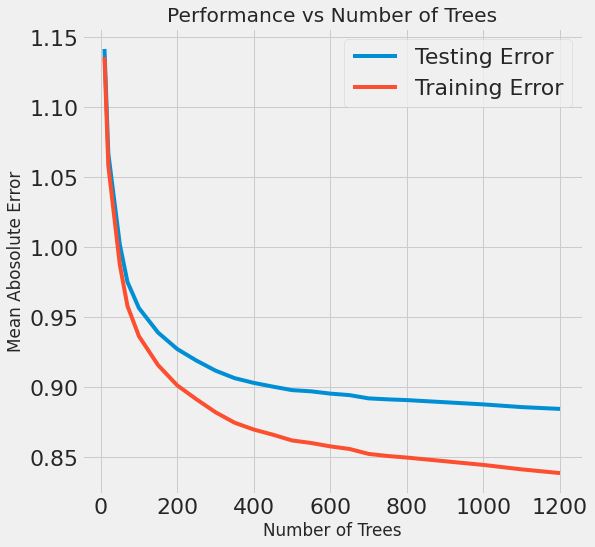

In [95]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)
# Plot the training and testing error vs number of trees
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [96]:
results.sort_values('mean_test_score', ascending = False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
21,101.272649,2.073288,0.241108,0.002903,1200,{'n_estimators': 1200},-0.880061,-0.858479,-0.876966,-0.922257,-0.884441,0.023340,1,-0.829926,-0.857413,-0.827665,-0.839442,-0.838612,0.011720
20,102.099483,0.669840,0.230189,0.004043,1100,{'n_estimators': 1100},-0.883345,-0.858859,-0.878049,-0.922690,-0.885736,0.023199,2,-0.834634,-0.858463,-0.830802,-0.841154,-0.841263,0.010597
19,104.750192,1.138473,0.216801,0.001102,1000,{'n_estimators': 1000},-0.886860,-0.859040,-0.879809,-0.924948,-0.887664,0.023832,3,-0.840357,-0.859063,-0.833619,-0.844721,-0.844440,0.009323
18,95.222406,1.217757,0.186674,0.020565,800,{'n_estimators': 800},-0.888490,-0.861378,-0.883306,-0.929782,-0.890739,0.024732,4,-0.843633,-0.863167,-0.839076,-0.852883,-0.849690,0.009235
17,93.534511,2.626124,0.187441,0.021033,750,{'n_estimators': 750},-0.888724,-0.861889,-0.883789,-0.930691,-0.891273,0.024898,5,-0.844396,-0.863714,-0.839564,-0.855597,-0.850817,0.009448


In [97]:
# Default model
default_model = GradientBoostingRegressor(random_state = 42)

# Select the best model
final_model = grid_search.best_estimator_

final_model

GradientBoostingRegressor(loss='lad', max_depth=5, min_samples_leaf=6,
                          min_samples_split=6, n_estimators=1200,
                          random_state=42)

In [98]:
%%timeit -n 1 -r 5
#https://ipython.readthedocs.io/en/stable/interactive/magics.html
default_model.fit(X, y)

4.28 s ± 24.6 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [99]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

1min 32s ± 153 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [100]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 0.9425.
Final model performance on the test set:   MAE = 0.8745.


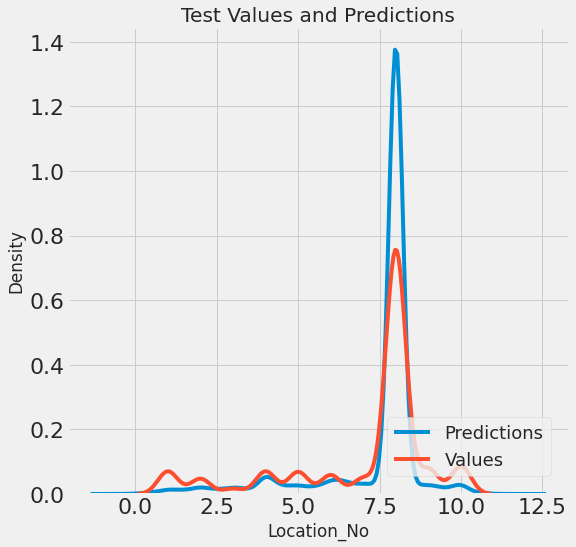

In [101]:
figsize(8, 8)

# Density plot of the final predictions and the test values
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

plt.legend(bbox_to_anchor=(1, 0), loc='lower right', borderaxespad=1, fontsize=18)
# Label the plot
plt.xlabel('Location_No'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

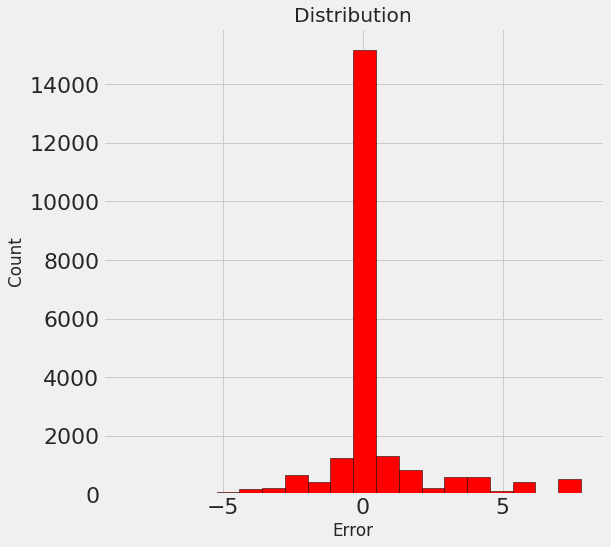

In [102]:
figsize = (6, 6)

# Calculate the residuals 
residuals = final_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribution');
#plt.title('Distribution of Residuals');

In [ ]:
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

In [ ]:
# Function to calculate accuracy
def accracy(y_true, total):
    true_positive_filter = (admissions["predicted_label"] == 1) & (admissions["actual_label"] == 1)
    true_positives = len(admissions[true_positive_filter])
    true_negative_filter = (admissions["predicted_label"] == 0) & (admissions["actual_label"] == 0)
    true_negatives = len(admissions[true_negative_filter])
    print(true_positives)
    print(true_negatives)

    
# Function to calculate sensity
def sensitivity(y_true, total):
    true_positive_filter = (admissions["predicted_label"] == 1) & (admissions["actual_label"] == 1)
    true_positives = len(admissions[true_positive_filter])
    false_negative_filter = (admissions["predicted_label"] == 0) & (admissions["actual_label"] == 1)
    false_negatives = len(admissions[false_negative_filter])
    sensitivity = true_positives / float((true_positives + false_negatives))
    print(sensitivity)

# Function to calculate specificity 
def specificity():
    true_positive_filter = (admissions["predicted_label"] == 1) & (admissions["actual_label"] == 1)
    true_positives = len(admissions[true_positive_filter])
    false_negative_filter = (admissions["predicted_label"] == 0) & (admissions["actual_label"] == 1)
    false_negatives = len(admissions[false_negative_filter])
    true_negative_filter = (admissions["predicted_label"] == 0) & (admissions["actual_label"] == 0)
    true_negatives = len(admissions[true_negative_filter])
    false_positive_filter = (admissions["predicted_label"] == 1) & (admissions["actual_label"] == 0)
    false_positives = len(admissions[false_positive_filter])
    specificity = (true_negatives) / float((false_positives + true_negatives))

[[50884   703   225   193    98    97    53    29    17    19]
 [  192 21197   398   125    56    55    40    19    12     4]
 [   21    66  7105   199    53    25    16     8     3     4]
 [   28    45    69 36684   283   169    77    78    50    13]
 [   29    47   126   317 41330  1014   229   167    50    57]
 [    9    54    67   183   494 29014  1093   450   127    56]
 [    7    30    27    66   106   400 28763   719   106    24]
 [    4    26    13    63   103   339  1140 27267   611   102]
 [    7    21    25    58    78   191   326  1008 49995   225]
 [   12    18    36    55   119   286   276   919  1906 34935]]
[ 1  2  3  4  5  6  7  8  9 10]


<ipython-input-70-410ec059a5f8>:36: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./images/maedropna_withprocess'+title+dt+'.png',quality=100,dpi=500)


<Figure size 576x720 with 0 Axes>

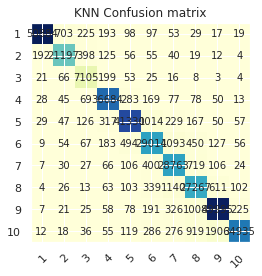

[[22372 10089  8938  5597  3483  1364   411    53    10     1]
 [   98  8173  8838  2840  1721   239   148    38     3     0]
 [    0   157  2695  1764  1858   845   156    23     2     0]
 [    1    22   599 25040  9248  1855   596   120    13     2]
 [   11   210   917  3407 15206 13364  7200  2812   217    22]
 [    1    50   240  1160  3190 15910  8662  2076   231    27]
 [    5    43   203   788  2024  4067 15782  6893   423    20]
 [    1    36    94   368  1899  3551  8023 14743   936    17]
 [   11    39   306  1065  2099  2291  7425 18736 19570   392]
 [    6    32   131   351  1123  1795  3616 10581 11512  9415]]
[ 1  2  3  4  5  6  7  8  9 10]


<ipython-input-70-410ec059a5f8>:36: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./images/maedropna_withprocess'+title+dt+'.png',quality=100,dpi=500)


<Figure size 432x576 with 0 Axes>

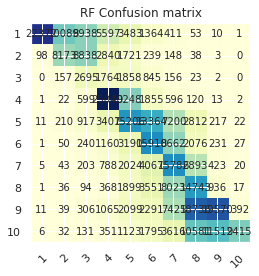

In [73]:
rf_cnf_matrix= make_confusion_matrix(y_test.to_array(), rf_pred.to_array())
print(rf_cnf_matrix)
plt.figure(figsize=(6,8))
plot_confusion_matrix(rf_cnf_matrix, title='RF Confusion matrix')
plt.show()

In [74]:
knn_cnf_matrix= make_confusion_matrix(y_test, gb_pred)
gb_cnf_matrix=gb_cnf_matrix[:10,:10]
print(gb_cnf_matrix)
plt.figure(figsize=(6,8))
plot_confusion_matrix(gb_cnf_matrix, title='GB Confusion matrix')
plt.show()

NameError: name 'gb_pred' is not defined

[ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 16. 17.]
[[   0    0    0    0   46  789  336   50    1    0]
 [   0    0    0    0   42  462  284   34    0    0]
 [   0    0    0    0   29  189   38   31    0    0]
 [   0    0    0    0   27  771  363   60    0    0]
 [   0    0    0    0   13  762  326   87    0    0]
 [   0    0    0    0   41  620  274   86    0    0]
 [   0    0    0    0   11  379  321  137    1    0]
 [   0    0    0    0   20  477 7037 5267  357   11]
 [   0    0    0    0   10  794  369  161    3    0]
 [   0    0    0    0   19  977  325  161    6    0]]
[ 1  2  3  4  5  6  7  8  9 10]


<Figure size 432x576 with 0 Axes>

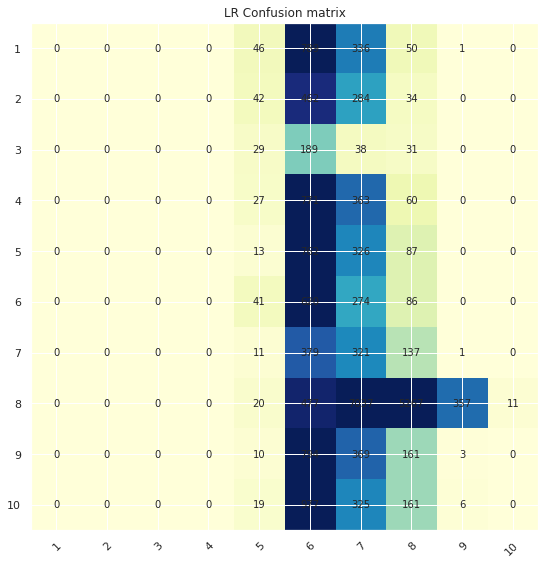

In [178]:
lr_cnf_matrix= make_confusion_matrix(y_test, lr_pred)
print(np.unique(lr_pred))

lr_cnf_matrix=lr_cnf_matrix[:10,:10]
print(lr_cnf_matrix)
plt.figure(figsize=(6,8))
plot_confusion_matrix(lr_cnf_matrix, title='LR Confusion matrix')
plt.show()
# pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])